[*********************100%***********************]  2 of 2 completed

## Overall Analysis
   Significant  Avg_Z_Score  Avg_CAR  Avg_Duration  Count
0        False      -0.0075   0.0016        0.0000     17
1         True       0.0519   0.0182       14.8101     79

## Abnormal Behavior Statistics
Average duration of abnormal behavior: 12.19 days
Median duration of abnormal behavior: 16.00 days
Percentage of positive abnormal behavior: 60.42%


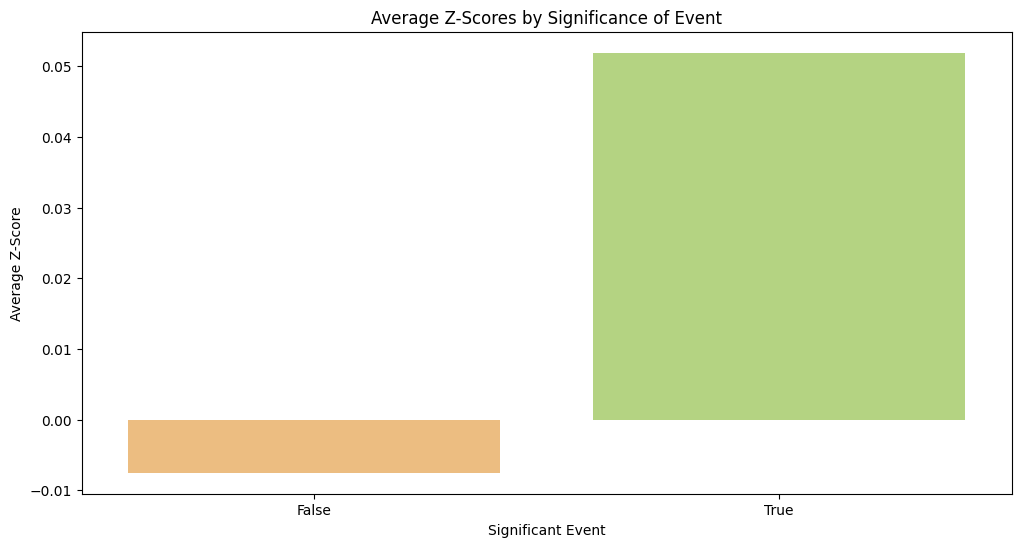

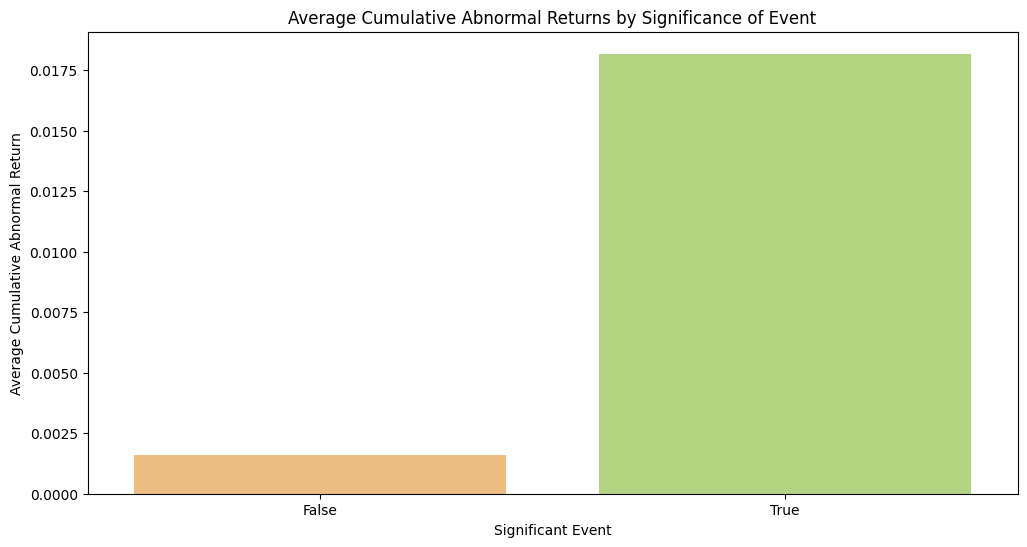

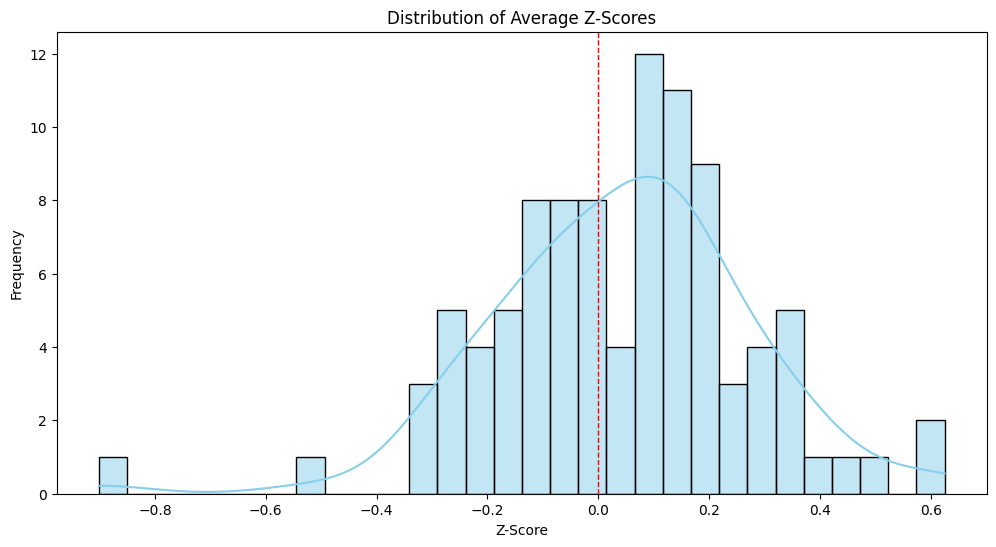

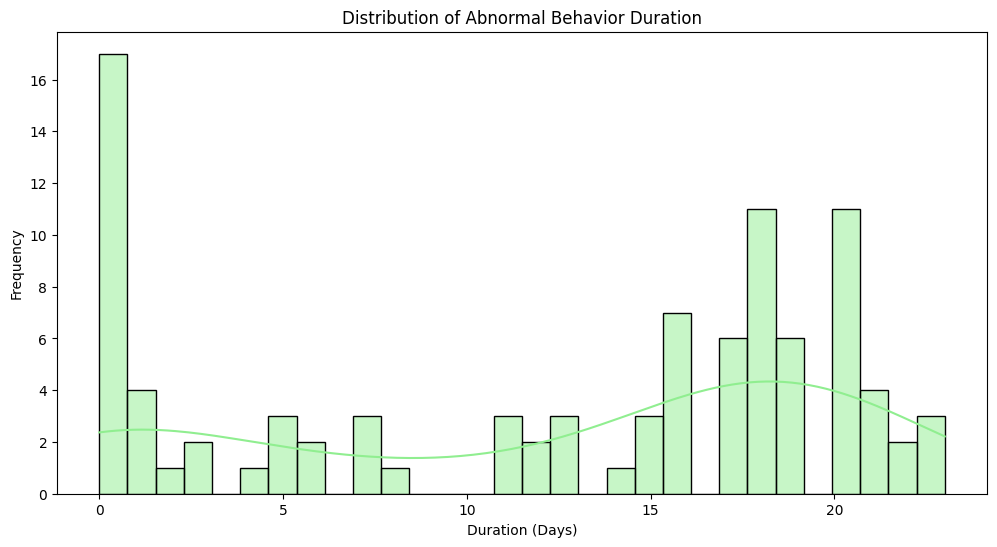

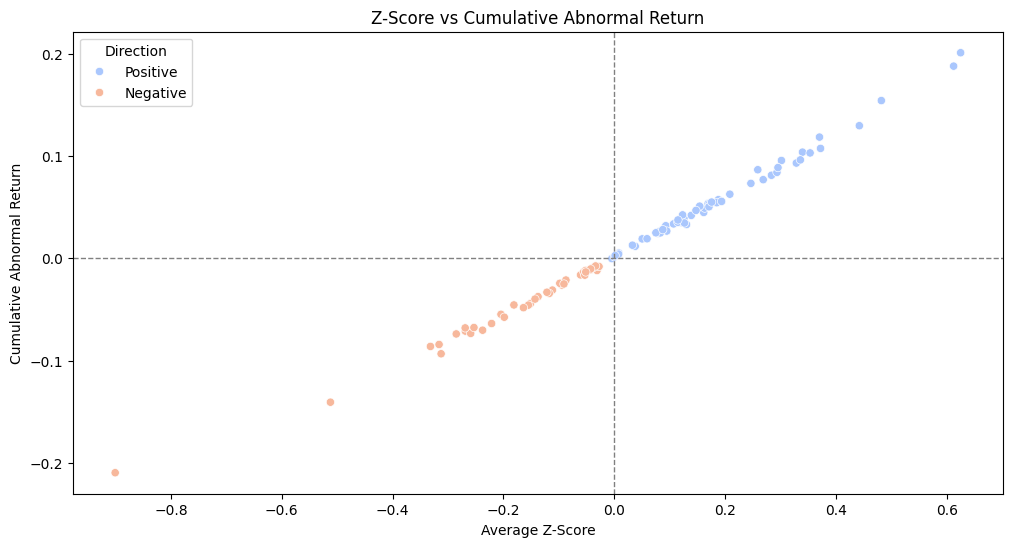

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta
import warnings
from scipy import stats
import seaborn as sns

# Suppress all warnings to keep the output clean
warnings.filterwarnings("ignore")

# Set display options for pandas to show all columns and format floats
pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:.4f}'.format)

# Define the tickers for XBI and IWM, and set the date range for data retrieval
tickers = ['XBI', 'IWM']
start_date = '2005-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Download historical adjusted close prices for the defined tickers within the date range
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns from the adjusted close prices and drop any missing values
returns = data.pct_change().dropna()

# Ensure that the index of returns is timezone-aware, localizing to UTC if necessary
if returns.index.tz is None:
    returns.index = returns.index.tz_localize('UTC')

def analyze_abnormal_returns(announcement_date, window=30):
    # Convert announcement date to datetime and ensure it is timezone-aware (UTC)
    event_start = pd.to_datetime(announcement_date)
    if event_start.tz is None:
        event_start = event_start.tz_localize('UTC')
    else:
        event_start = event_start.tz_convert('UTC')

    # Define the end of the event window (30 days after announcement)
    event_end = event_start + pd.Timedelta(days=window)

    # Extract returns during the event window
    event_returns = returns.loc[event_start:event_end]
    if event_returns.empty:
        return None  # Return None if no data is available for this period

    # Calculate abnormal returns for XBI relative to IWM during the event window
    xbi_abnormal = event_returns['XBI'] - event_returns['IWM']

    # Compute historical mean and standard deviation of differences between XBI and IWM returns
    historical_diff = returns['XBI'] - returns['IWM']
    historical_mean = historical_diff.mean()
    historical_std = historical_diff.std()

    # Calculate z-scores and p-values for abnormal returns to assess significance
    z_scores = (xbi_abnormal - historical_mean) / historical_std
    p_values = 1 - stats.norm.cdf(np.abs(z_scores))

    return z_scores, xbi_abnormal, p_values

# Load merger and acquisition deals data from CSV file, ensuring dates are parsed correctly and localized to UTC
df_ma = pd.read_csv("XBI_Deals_CSV.csv")
df_ma['Date Announced'] = pd.to_datetime(df_ma['Date Announced'], format='%b-%y')
df_ma['Date Announced'] = df_ma['Date Announced'].dt.tz_localize('UTC')

# Initialize a list to store results of analysis for each announcement date
results = []

# Loop through each unique announcement date in the deals data to analyze abnormal returns
for announcement_date in df_ma['Date Announced'].unique():
    analysis_result = analyze_abnormal_returns(announcement_date)

    if analysis_result is None:
        continue  # Skip if no data is available for this announcement

    z_scores, xbi_abnormal, p_values = analysis_result

    # Determine duration of significant abnormal behavior based on p-values (< 0.05)
    significant_days = np.where(p_values < 0.05)[0]
    duration = significant_days[-1] + 1 if len(significant_days) > 0 else 0

    # Determine direction of abnormal behavior based on mean abnormal return
    direction = "Positive" if xbi_abnormal.mean() > 0 else "Negative"

    # Append results including average z-score, cumulative abnormal return, significance, duration, and direction
    results.append({
        'Announcement Date': announcement_date,
        'Avg Z-Score': z_scores.mean(),
        'Cumulative Abnormal Return': (1 + xbi_abnormal).prod() - 1,
        'Significant': np.any(p_values < 0.05),
        'Duration': duration,
        'Direction': direction
    })

# Convert results list into a DataFrame for further analysis and visualization
results_df = pd.DataFrame(results)

# Calculate summary statistics: average duration, median duration, percentage of positive behavior
avg_duration = results_df['Duration'].mean()
median_duration = results_df['Duration'].median()
positive_percentage = (results_df['Direction'] == 'Positive').mean() * 100

# Group by significance to calculate overall analysis metrics like average z-score and cumulative abnormal return (CAR)
overall_analysis = results_df.groupby('Significant').agg(
    Avg_Z_Score=('Avg Z-Score', 'mean'),
    Avg_CAR=('Cumulative Abnormal Return', 'mean'),
    Avg_Duration=('Duration', 'mean'),
    Count=('Announcement Date', 'count')
).reset_index()

# Print overall analysis results and summary statistics for interpretation
print("## Overall Analysis")
print(overall_analysis)

print("\n## Abnormal Behavior Statistics")
print(f"Average duration of abnormal behavior: {avg_duration:.2f} days")
print(f"Median duration of abnormal behavior: {median_duration:.2f} days")
print(f"Percentage of positive abnormal behavior: {positive_percentage:.2f}%")

# Visualize results using seaborn bar plots and histograms to illustrate findings clearly

plt.figure(figsize=(12, 6))
sns.barplot(x='Significant', y='Avg_Z_Score', data=overall_analysis, palette='RdYlGn')
plt.title('Average Z-Scores by Significance of Event')
plt.xlabel('Significant Event')
plt.ylabel('Average Z-Score')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Significant', y='Avg_CAR', data=overall_analysis, palette='RdYlGn')
plt.title('Average Cumulative Abnormal Returns by Significance of Event')
plt.xlabel('Significant Event')
plt.ylabel('Average Cumulative Abnormal Return')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=results_df, x='Avg Z-Score', kde=True, color='skyblue', bins=30)
plt.title('Distribution of Average Z-Scores')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=results_df, x='Duration', kde=True, color='lightgreen', bins=30)
plt.title('Distribution of Abnormal Behavior Duration')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='Avg Z-Score', y='Cumulative Abnormal Return', hue='Direction', palette='coolwarm')
plt.title('Z-Score vs Cumulative Abnormal Return')
plt.xlabel('Average Z-Score')
plt.ylabel('Cumulative Abnormal Return')
plt.axhline(0, color='grey', linestyle='dashed', linewidth=1)
plt.axvline(0, color='grey', linestyle='dashed', linewidth=1)
plt.legend(title='Direction')
plt.show()

### Summary of Findings
1. **Key Events**:
   - **True Events (Significant)**:
     - On average, these events lead to a small positive change in stock performance (Z-Score of 0.0519) over about 15 days, with 79 such events analyzed.
   - **False Events (Not Significant)**:
     - These generally show no impact on performance (Z-Score of -0.0075) and don’t last any time at all, with only 17 events.

2. **Abnormal Behavior**:
   - The unusual stock performance lasts about 12 days on average, with a median of 16 days.
   - About 60% of the time, these abnormal performances are positive.

### Visual Insights
1. **Z-Scores Comparison**:
   - Significant events generally have higher Z-scores, indicating they have more noticeable impacts compared to non-significant events.

2. **Cumulative Returns**:
   - Significant announcements also lead to better returns on average.

3. **Distribution of Scores**:
   - Most scores are near zero but lean slightly towards the positive side.

4. **Duration of Abnormal Behavior**:
   - Many events show little to no impact, but some do last longer, suggesting varying effects.

### Overall Takeaway
Significant announcements about XBI tend to result in noticeable positive stock performance that lasts for a while.

### Visualization Breakdown
- **Data Collection**: Prices of XBI and a comparison index (IWM) were gathered to study how they moved around announcement dates.
- **Abnormal Returns Analysis**: The analysis determined how much XBI's performance deviated from IWM’s during these events.
- **Results Compilation**: Key metrics like average performance change (Z-scores and cumulative returns) were calculated and organized for analysis.
- **Visualization**: A scatter plot illustrates the relationship between the average Z-scores and cumulative abnormal returns, with colors indicating whether the performance was positive or negative.

### Plot Insights
- **X-Axis**: Shows the average Z-Score.
- **Y-Axis**: Shows cumulative abnormal return.
- **Color Coding**: 
  - Blue dots indicate positive returns.
  - Orange dots indicate negative returns.
  
There’s a clear trend: higher Z-scores generally mean better financial performance after significant announcements. This helps us understand how major events influence stock prices.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta
import warnings
from scipy import stats
import seaborn as sns

# Suppress all warnings to keep the output clean
warnings.filterwarnings("ignore")

# Set display options for pandas to show all columns and format floats
pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:.4f}'.format)

# Define the tickers for XBI and IWM, and set the date range for data retrieval
tickers = ['XBI', 'IWM']
start_date = '2005-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Download historical adjusted close prices for the defined tickers within the date range
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns from the adjusted close prices and drop any missing values
returns = data.pct_change().dropna()

# Ensure that the index of returns is timezone-aware, localizing to UTC if necessary
if returns.index.tz is None:
    returns.index = returns.index.tz_localize('UTC')


# Load merger and acquisition deals data from CSV file, ensuring dates are parsed correctly and localized to UTC
df_ma = pd.read_csv("XBI_Deals_CSV.csv")
df_ma['Date Announced'] = pd.to_datetime(df_ma['Date Announced'], format='%b-%y')
df_ma['Date Announced'] = df_ma['Date Announced'].dt.tz_localize('UTC')

[*********************100%***********************]  2 of 2 completed


In [8]:
data

Ticker,IWM,XBI
Date,,
2005-01-03 00:00:00+00:00,51.1621,NaN
2005-01-04 00:00:00+00:00,50.0654,NaN
2005-01-05 00:00:00+00:00,49.0647,NaN
2005-01-06 00:00:00+00:00,49.3249,NaN
2005-01-07 00:00:00+00:00,48.7765,NaN
...,...,...
2024-10-07 00:00:00+00:00,217.4300,96.3300
2024-10-08 00:00:00+00:00,217.5800,97.1000
2024-10-09 00:00:00+00:00,218.0600,96.3100


[*********************100%***********************]  1 of 1 completed


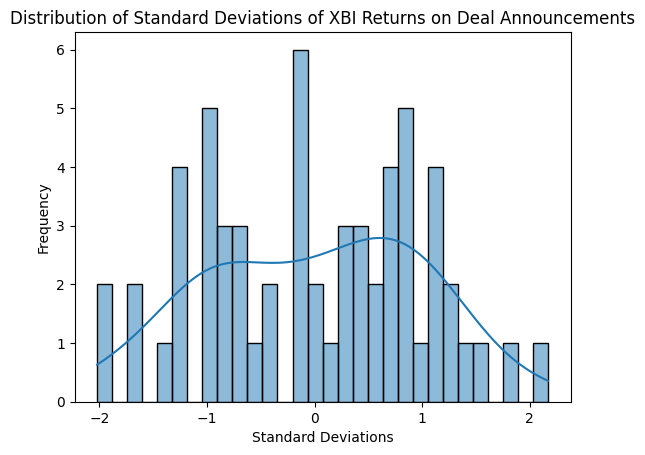

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import seaborn as sns

# Suppress all warnings to keep the output clean
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:.4f}'.format)

# Define the tickers for XBI and set the date range for data retrieval
tickers = ['XBI']
start_date = '2005-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Download historical adjusted close prices for XBI
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns and drop any missing values
returns = data.pct_change().dropna()

# Ensure timezone awareness
if returns.index.tz is None:
    returns.index = returns.index.tz_localize('UTC')

# Load merger and acquisition deals data from CSV file
df_ma = pd.read_csv("XBI_Deals_CSV.csv")
df_ma['Date Announced'] = pd.to_datetime(df_ma['Date Announced'], format='%b-%y')
df_ma['Date Announced'] = df_ma['Date Announced'].dt.tz_localize('UTC')

# Merge deal announcement dates with returns
deal_returns = returns[returns.index.isin(df_ma['Date Announced'])]

# Calculate average and standard deviation of returns for deal announcement dates
mean_return = deal_returns.mean()
std_dev_return = deal_returns.std()

# Calculate how many standard deviations away each return is from the mean
deal_returns['Std Deviations'] = (deal_returns - mean_return) / std_dev_return

# Optional: Plot the distribution of returns
sns.histplot(deal_returns['Std Deviations'], bins=30, kde=True)
plt.title('Distribution of Standard Deviations of XBI Returns on Deal Announcements')
plt.xlabel('Standard Deviations')
plt.ylabel('Frequency')
plt.show()


[*********************100%***********************]  1 of 1 completed


               Metric  Value
0         Mean Return 0.0015
1  Standard Deviation 0.0211


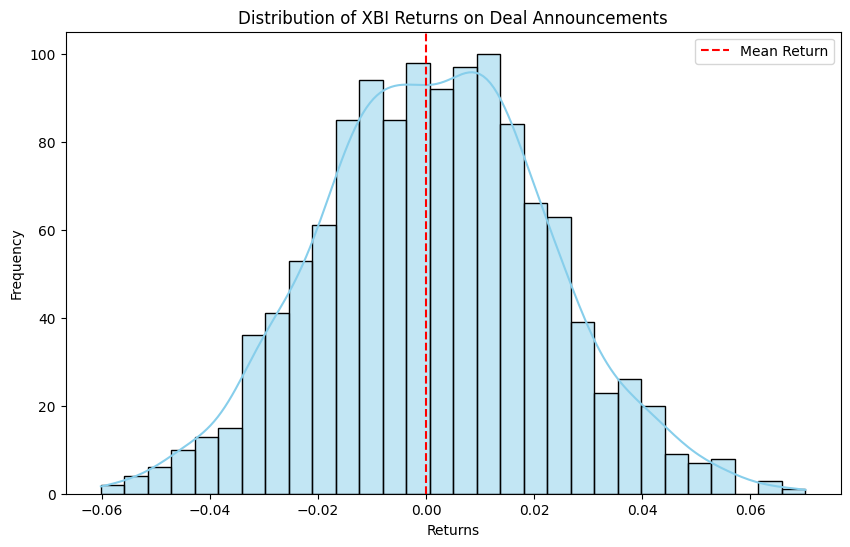

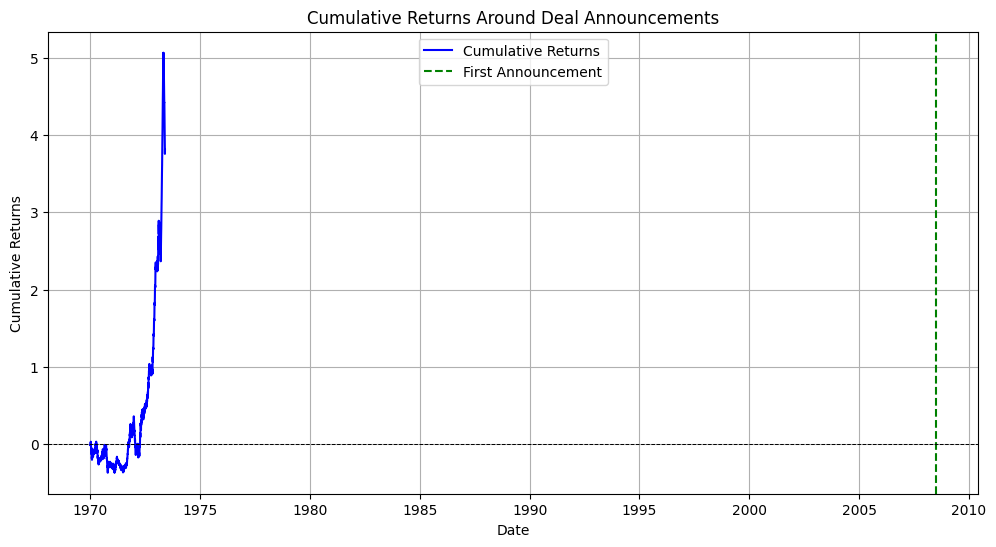

T-statistic: 2.4803, P-value: 0.0133

Highest Impact Deals:
               Date Announced  Absolute Return  Max Return  Min Return
33  2016-04-01 00:00:00+00:00           0.1440      0.0702     -0.0130
107 2022-08-01 00:00:00+00:00           0.1308      0.0553     -0.0205
108 2022-08-01 00:00:00+00:00           0.1308      0.0553     -0.0205
109 2022-08-01 00:00:00+00:00           0.1308      0.0553     -0.0205
154 2024-05-01 00:00:00+00:00           0.0981      0.0320     -0.0105

Lowest Impact Deals:
               Date Announced  Absolute Return  Max Return  Min Return
103 2022-05-01 00:00:00+00:00          -0.1445      0.0400     -0.0602
34  2016-05-01 00:00:00+00:00          -0.1318      0.0198     -0.0416
35  2016-05-01 00:00:00+00:00          -0.1318      0.0198     -0.0416
36  2016-05-01 00:00:00+00:00          -0.1318      0.0198     -0.0416
3   2009-03-01 00:00:00+00:00          -0.1249      0.0279     -0.0530

High Impact Deals Analysis:
             Date Announced  Absolute

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from scipy import stats

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Define the tickers and date range
tickers = ['XBI']
start_date = '2005-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Download historical data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Ensure timezone awareness
if returns.index.tz is None:
    returns.index = returns.index.tz_localize('UTC')

# Load M&A deals data
df_ma = pd.read_csv("XBI_Deals_CSV.csv")
df_ma['Date Announced'] = pd.to_datetime(df_ma['Date Announced'], format='%b-%y', errors='coerce').dt.tz_localize('UTC')

# Define event window
event_window = 5
event_dates = df_ma['Date Announced']

# Create a DataFrame to store returns around event dates
event_returns = pd.DataFrame()

for event_date in event_dates:
    window = returns.loc[(returns.index >= event_date - pd.Timedelta(days=event_window)) & 
                         (returns.index <= event_date + pd.Timedelta(days=event_window))]
    window = window.reset_index()
    window['Event Date'] = event_date
    event_returns = pd.concat([event_returns, window], ignore_index=True)

# Calculate statistics
mean_return = event_returns['Adj Close'].mean()
std_dev_return = event_returns['Adj Close'].std()

# Display summary statistics in a more readable format
summary_df = pd.DataFrame({
    'Metric': ['Mean Return', 'Standard Deviation'],
    'Value': [mean_return, std_dev_return]
})
print(summary_df)

# Plot the distribution of returns
plt.figure(figsize=(10, 6))
sns.histplot(event_returns['Adj Close'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of XBI Returns on Deal Announcements')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label='Mean Return')
plt.legend()
plt.show()

# Cumulative Returns Visualization
cumulative_returns = (1 + event_returns['Adj Close']).cumprod() - 1
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns Around Deal Announcements')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.axvline(df_ma['Date Announced'].min(), color='green', linestyle='--', label='First Announcement')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.legend()
plt.grid()
plt.show()

# Hypothesis Testing
t_stat, p_value = stats.ttest_1samp(event_returns['Adj Close'].dropna(), 0)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

# Calculate absolute returns around each deal announcement
deal_impact = []

for event_date in event_dates:
    window = returns.loc[(returns.index >= event_date - pd.Timedelta(days=event_window)) & 
                         (returns.index <= event_date + pd.Timedelta(days=event_window))]
    
    if not window.empty:
        abs_return = window.sum()
        deal_impact.append({
            'Date Announced': event_date,
            'Absolute Return': abs_return,
            'Max Return': window.max(),
            'Min Return': window.min(),
        })

deal_impact_df = pd.DataFrame(deal_impact)

# Identify highest and lowest impact deals
highest_impact_deals = deal_impact_df.nlargest(5, 'Absolute Return')
lowest_impact_deals = deal_impact_df.nsmallest(5, 'Absolute Return')

print("\nHighest Impact Deals:")
print(highest_impact_deals)

print("\nLowest Impact Deals:")
print(lowest_impact_deals)

# Analyze factors contributing to high impact
def analyze_high_impact_deals(high_impact_df):
    high_impact_deals = []
    
    for index, row in high_impact_df.iterrows():
        deal_info = df_ma[df_ma['Date Announced'] == row['Date Announced']].iloc[0]
        
        high_impact_deals.append({
            'Date Announced': row['Date Announced'],
            'Absolute Return': row['Absolute Return'],
            'Deal Size ($B)': deal_info['Deal Value \n($B)'],  # Actual deal value
            'Industry Relevance': deal_info['Primary Indication']  # Example relevance factor
        })

    return pd.DataFrame(high_impact_deals)

high_impact_analysis = analyze_high_impact_deals(highest_impact_deals)
print("\nHigh Impact Deals Analysis:")
print(high_impact_analysis)
